In [1]:
from src.dataset import ImageNetSubset
from torchvision import transforms
import os
from torch.utils.tensorboard import SummaryWriter
import time
import torch


In [17]:
root_train = os.path.join('..', 'data', 'ImageNetSubset')
root_test = ...


transform = transforms.Compose([
    transforms.Resize((256,192)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



dataset_train = ImageNetSubset(root=root_train, transform=transform)
dataset_test = CustomImageDataset(root=root_test, transform=transform)


In [19]:
import torch
import torchvision
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset_train,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42),
)

batch_size = 4

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False, num_workers=2)


classes = ('coffee-mug', 'notebook', 'remote-control', 'soup-bowl', 'teapot', 'wooden-spoon', 'computer-keyboard', 'mouse', 'binder', 'toilet-tissue')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


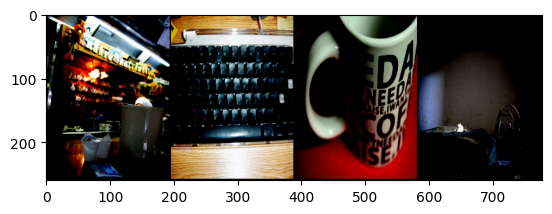

coffee-mug computer-keyboard coffee-mug binder


In [20]:
import matplotlib.pyplot as plt

dataiter = iter(trainloader)
images, labels = next(dataiter)

def imshow(img):
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.show()

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, input_size=(32, 32)):
        super().__init__()

        # Convs wie im Original (nur in_channels variabel)
        self.conv1 = nn.Conv2d(in_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Hier bestimmen wir automatisch die Größe für fc1:
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, *input_size)  # (1, C, H, W)
            x = self.pool(F.relu(self.conv1(dummy)))
            x = self.pool(F.relu(self.conv2(x)))
            n_features = x.view(1, -1).size(1)  # Anzahl Features nach Conv+Pool

        self.fc1 = nn.Linear(n_features, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net(in_channels=3, num_classes=10, input_size=(256, 192))

In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#### first training loop without tracking or validation

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.281
[2,  2000] loss: 2.119
Finished Training


In [24]:
#### training loop with TensorBoard tracking and validation

# checks if GPU is available and moves the model to GPU if so
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
print(device)

writer = SummaryWriter(log_dir=f'./runs/exp_{int(time.time())}')

num_epochs = 5
for epoch in range(num_epochs):
    net.train()
    running_loss_sum = 0.0
    train_samples = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        bs = inputs.size(0)
        running_loss_sum += loss.item() * bs
        train_samples += bs
    
    avg_train_loss = running_loss_sum / train_samples
    writer.add_scalar('Loss/train_epoch', avg_train_loss, epoch)

    # Validation loop
    net.eval()
    val_loss_sum = 0.0
    val_samples = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            bs = inputs.size(0)
            val_loss_sum += loss.item() * bs
            val_samples += bs
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss_sum / val_samples if val_samples > 0 else 0.0
    val_acc = correct / val_samples if val_samples > 0 else 0.0

    writer.add_scalar('Loss/val_epoch', avg_val_loss, epoch)
    writer.add_scalar('Accuracy/val_epoch', val_acc, epoch)

    print(f'Epoch {epoch+1}/{num_epochs} - train_loss: {avg_train_loss:.4f}  val_loss: {avg_val_loss:.4f}  val_acc: {val_acc:.4f}')

print('Finished Training')
writer.close()

Epoch 1/5 - train_loss: 2.1024  val_loss: 2.0743  val_acc: 0.2444
Epoch 2/5 - train_loss: 2.0063  val_loss: 2.0134  val_acc: 0.2804
Epoch 3/5 - train_loss: 1.8867  val_loss: 2.0011  val_acc: 0.3041
Epoch 4/5 - train_loss: 1.6663  val_loss: 1.9206  val_acc: 0.3341
Epoch 5/5 - train_loss: 1.3338  val_loss: 2.1229  val_acc: 0.3230
Finished Training


In [ ]:
# save trained model
# ACHTUNG: Dateinamen anpassen! sonst wird altes Modell überschrieben
PATH = './models/image_net_2511xx.pth'
torch.save(net.state_dict(), PATH)


# Tensorboard in Konsole starten mit:
# tensorboard --logdir=./runs